In [1]:
import numpy as np
import gym
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import matplotlib as mpl
from math import exp
mpl.style.use('classic')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.distributions import Categorical, Bernoulli


#from FourRoomsLava import Fourrooms,FourroomsLava
import sys
sys.path.insert(1, "..")
from tworooms import Tworooms
from fourrooms import FourroomsDist
from models import *

In [2]:
layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""

In [3]:
def getEnvLayout(layout,wall_value=20, lava=True, danger=True):
    num_row = 13
    num_col = 13
    line_count = 0
    mat_layout = -2*np.ones((num_row, num_col))
    mapping_state_row_col = defaultdict(list)
    ann_layout = np.zeros((num_row, num_col))
    state_count = 0
    for line in layout.splitlines():
        for i in range(num_col):
            if line[i]!="w":
                mapping_state_row_col[state_count].extend([line_count, i])
                ann_layout[line_count, i] = state_count
                state_count +=1            
            if line[i] == "d" and danger == True:
                mat_layout[line_count, i] = 5
            elif line[i] == "L" and lava == True:
                mat_layout[line_count, i] = 10
            elif line[i]=="w":
                    mat_layout[line_count, i] = 0.5
            elif line[i]=="G":
                    mat_layout[line_count, i] = 0
                    
        line_count +=1

    return mat_layout, ann_layout, mapping_state_row_col

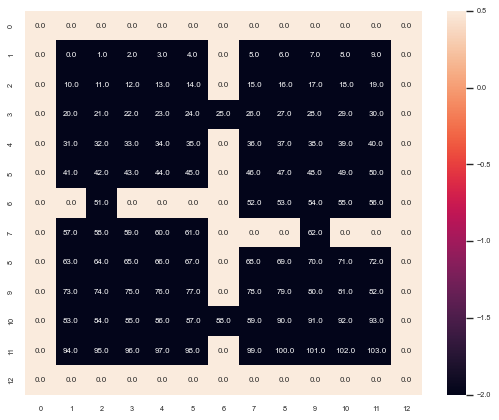

[7, 9]


In [4]:
#graphical representation for the environment
plt.figsize=(10, 8)
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
sn.set(font_scale=0.6)
ax = sn.heatmap(mat_layout, annot = ann_layout, fmt = '')
plt.show()
plt.close()
print(mapping_state_row_col[62])

In [5]:
!ls Trained_Models

FourroomsOnehot


In [14]:
file_num = 11
env_type = "FourRoomsOnehot"
state_sd = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/State_model.pt")
policy_sd = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/Policy_over_options.pt")
interest_policy_sd = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/Interest_Policy_over_options.pt")
termination_sd = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/Option_termination.pt")
option_sd = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/Option_policies.pt")
#train_steps = torch.load("Trained_Models/" + env_type + "/"+ str(file_num) + "/episode_steps.pt")

In [15]:
env = gym.make('FourroomsOnehot-v0')
num_actions  = env.action_space.n
num_states = env.observation_space.n
num_options = 4

obs = env.reset()
print(state_sd['features.0.weight'].size())
state_model = StateModel(len(obs), 32)
policy_over_options = PolicyOverOptions(123, len(obs), num_options, eps_decay=20000)
interest_policy_over_options = InterestPolicyOverOptions(123, len(obs), num_options, policy_over_options, eps_decay=20000)
option_policies = SoftmaxPolicy(len(obs), num_options, num_actions)
option_termination = Termination(len(obs), num_options)

Occupancy =  [[1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 0 1 1 1 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 1 1 0 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
Observation Space =  Discrete(104)
To state =  {(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4, (1, 7): 5, (1, 8): 6, (1, 9): 7, (1, 10): 8, (1, 11): 9, (2, 1): 10, (2, 2): 11, (2, 3): 12, (2, 4): 13, (2, 5): 14, (2, 7): 15, (2, 8): 16, (2, 9): 17, (2, 10): 18, (2, 11): 19, (3, 1): 20, (3, 2): 21, (3, 3): 22, (3, 4): 23, (3, 5): 24, (3, 6): 25, (3, 7): 26, (3, 8): 27, (3, 9): 28, (3, 10): 29, (3, 11): 30, (4, 1): 31, (4, 2): 32, (4, 3): 33, (4, 4): 34, (4, 5): 35, (4, 7): 36, (4, 8): 37, (4, 9): 38, (4, 10): 39, (4, 11): 40, (5, 1): 41, (5, 2): 42, (5, 3): 43, (5, 4): 44, (5, 5): 45, (5, 7): 46,

In [16]:
obs = env.reset()
print(env.currentcell)
print(env.states[(env.currentcell[0],env.currentcell[1])])

(10, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


# Print Initial Interest

Option  0
Option  1
Option  2
Option  3


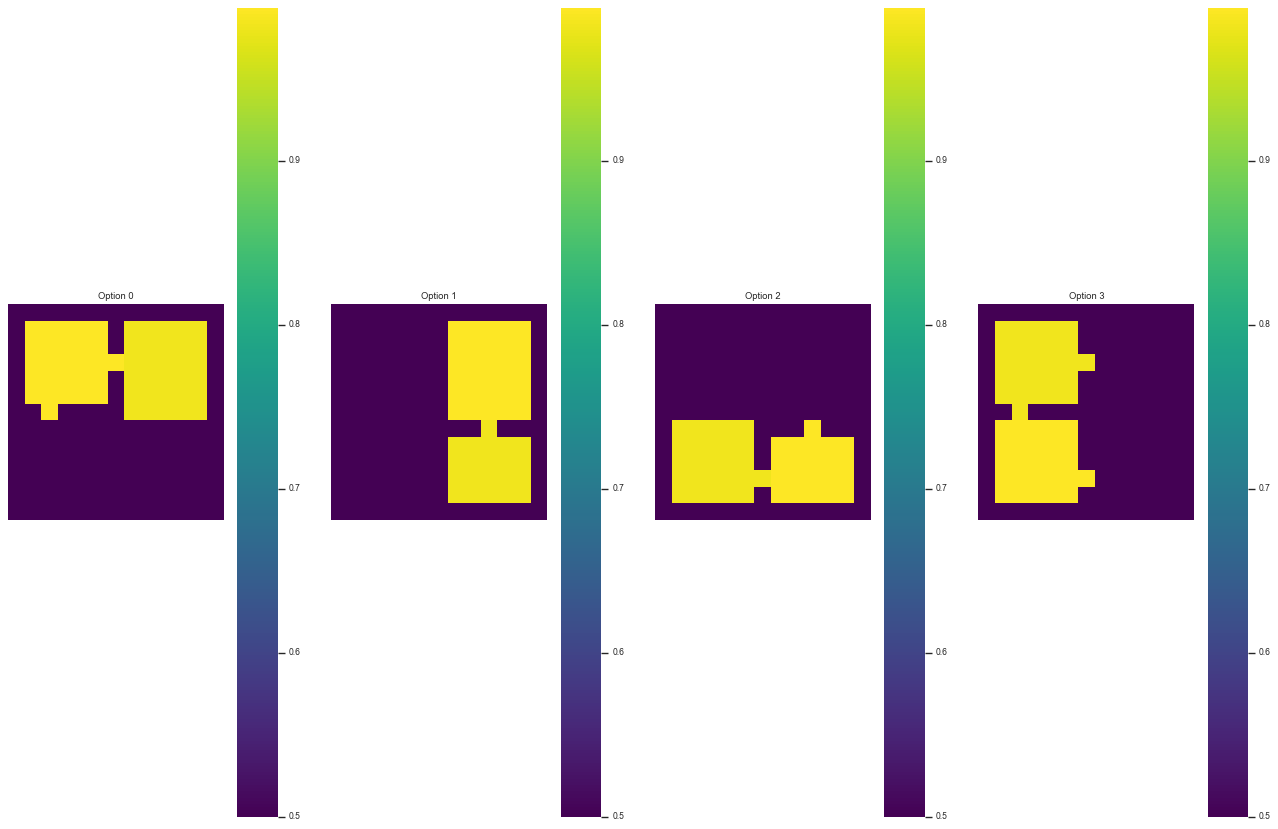

In [17]:
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
num_options = 4
init_states = list(range(env.observation_space.n))
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)

initial_int_mats = []

for option in range(num_options):
    print ("Option ",option)    
    for obs in init_states:
        r, c = mapping_state_row_col[obs]
        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()
        interest = interest_policy_over_options.get_interest(state, option)
        #print(interest)
        mat_layout[r,c] = interest.item()
    
    sn.set(font_scale=0.7)
    #ax = sn.heatmap(mat_layout, annot = np.round(ann_layout,2), fmt = '', cmap="YlGnBu", cbar = True, square=True)
    ax[option] = sn.heatmap(mat_layout, fmt = '', cmap="viridis", cbar = True, square=True, ax = ax[option])
    ax[option].get_xaxis().set_visible(False)
    ax[option].get_yaxis().set_visible(False)
    ax[option].set_title("Option " + str(option))
    initial_int_mats.append(np.copy(mat_layout))
plt.show()
plt.close()

# Print Final Interest

In [18]:
#state_model.load_state_dict(state_sd)
policy_over_options.load_state_dict(policy_sd)
interest_policy_over_options.load_state_dict(interest_policy_sd)
option_termination.load_state_dict(termination_sd)
option_policies.load_state_dict(option_sd)

<All keys matched successfully>

Option  0
Option  1
Option  2
Option  3


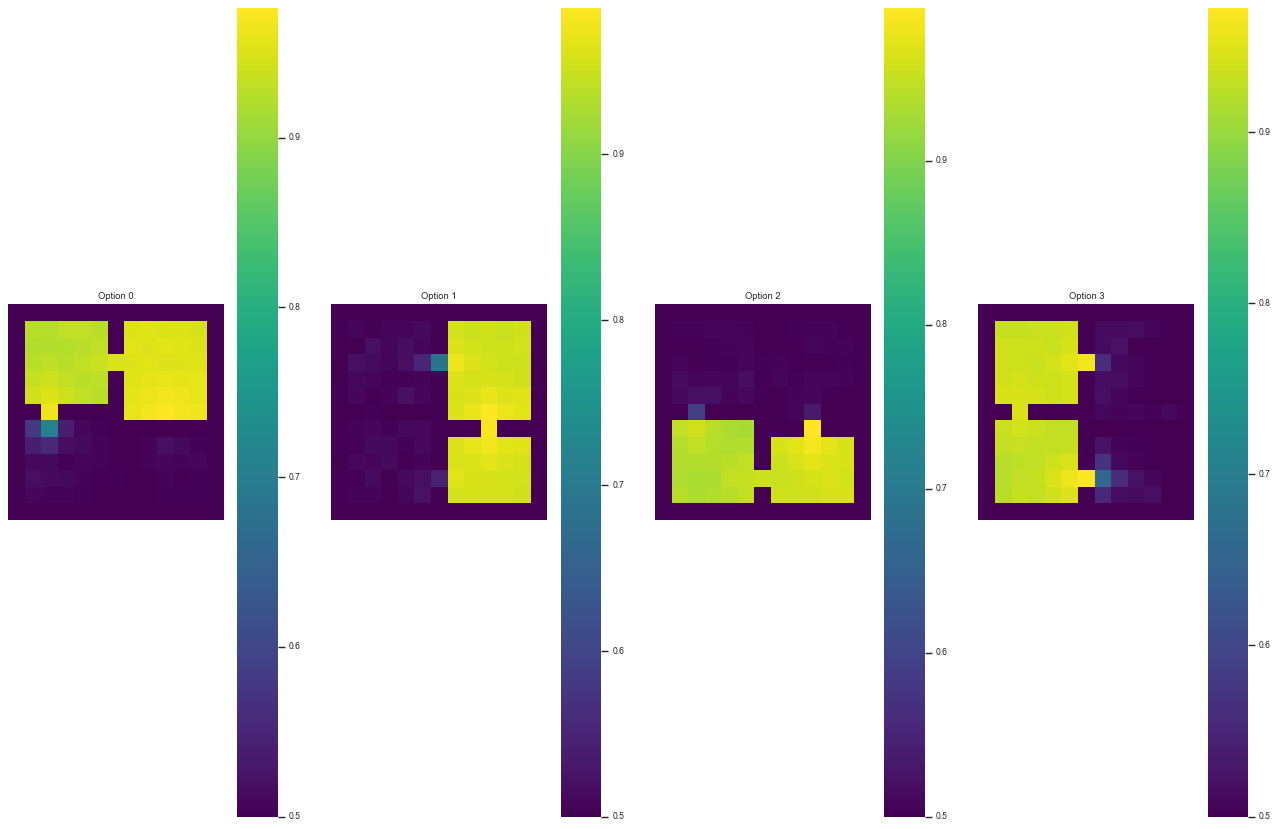

In [19]:
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
num_options = 4
init_states = list(range(env.observation_space.n))
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)

final_interest = []

for option in range(num_options):
    print ("Option ",option)    
    for obs in init_states:
        r, c = mapping_state_row_col[obs]
        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()
        interest = interest_policy_over_options.get_interest(state, option)
        #print(interest)
        mat_layout[r,c] = interest.item()
    
    sn.set(font_scale=0.7)
    #ax = sn.heatmap(mat_layout, annot = np.round(ann_layout,2), fmt = '', cmap="YlGnBu", cbar = True, square=True)
    ax[option] = sn.heatmap(mat_layout, fmt = '', cmap="viridis", cbar = True, square=True, ax = ax[option])
    ax[option].get_xaxis().set_visible(False)
    ax[option].get_yaxis().set_visible(False)
    ax[option].set_title("Option " + str(option))
    final_interest.append(np.copy(mat_layout))
plt.show()
plt.close()

# Visualize Termination

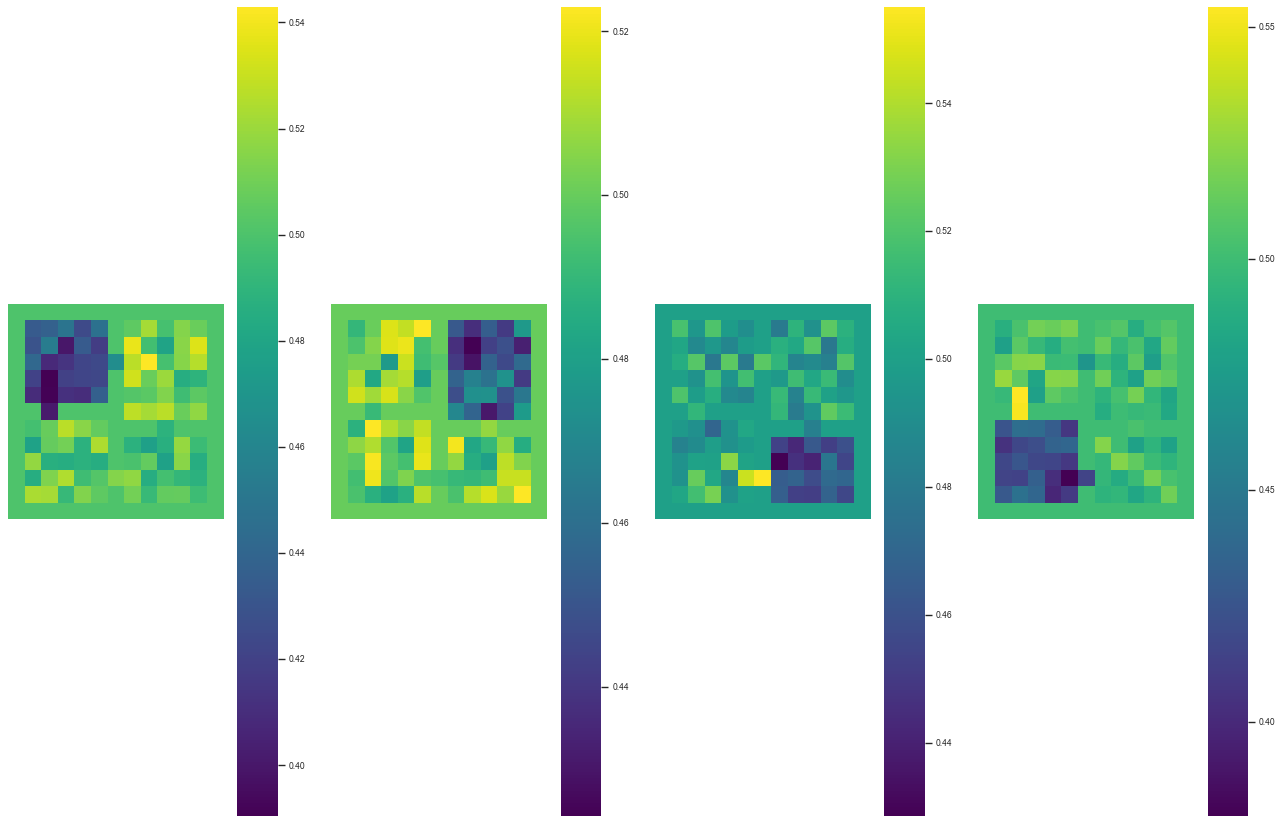

In [20]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

mat_layout, ann_layout, mapping_state_row_col = getEnvLayout(layout,wall_value=0.60)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
term_mats = []
init_states = list(range(env.observation_space.n))
for option in range(num_options):
    for obs in init_states:
        r, c = mapping_state_row_col[obs]
        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()
        #state = state_model(state)
        #print(option_termination.terminations(state))
        termination = option_termination.terminations(state).detach().numpy()
        #print(termination)
        option_termination_val = termination[option]
        #print(termination)
        #print(option_termination_val)
        mat_layout[r,c] = termination[option].item()
        #ann_layout[r,c] = round(termination[option],2)
        
    sn.set(font_scale=0.7)
    #ax = sn.heatmap(mat_layout, annot = np.round(ann_layout,2), fmt = '', cmap="YlGnBu", cbar = True, square=True)
    ax[option] = sn.heatmap(mat_layout, fmt = '', cmap="viridis", cbar = True, square=True, ax = ax[option])
    term_mats.append(np.copy(mat_layout))
    ax[option].get_xaxis().set_visible(False)
    ax[option].get_yaxis().set_visible(False)
#     plt.savefig((os.path.join(path,"IOC_FinalBeta_O"+ str(option) +".png")), dpi=200, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#                 transparent=False, bbox_inches='tight', pad_inches=0,
#                 frameon=None, figsize=(5, 5))
plt.show()
plt.close()

# Option Policies

Done with option  0
Done with option  1
Done with option  2
Done with option  3
Option  0


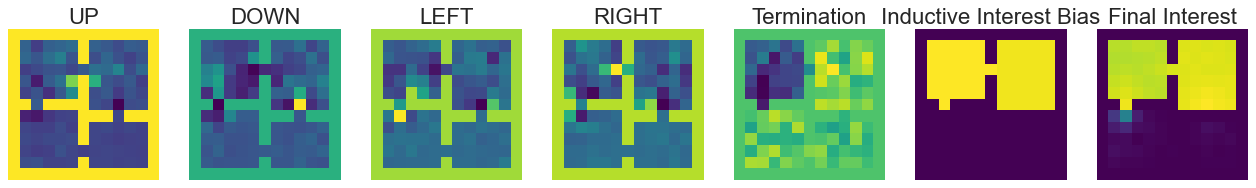

Option  1


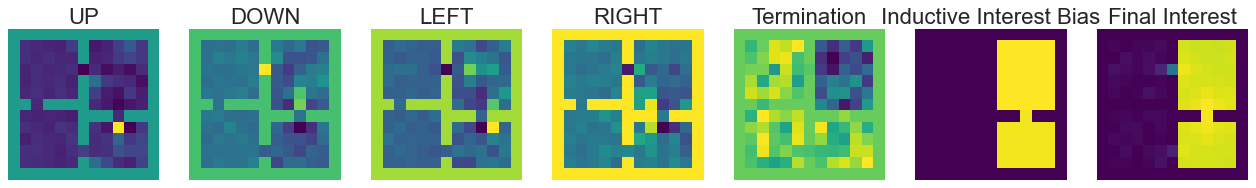

Option  2


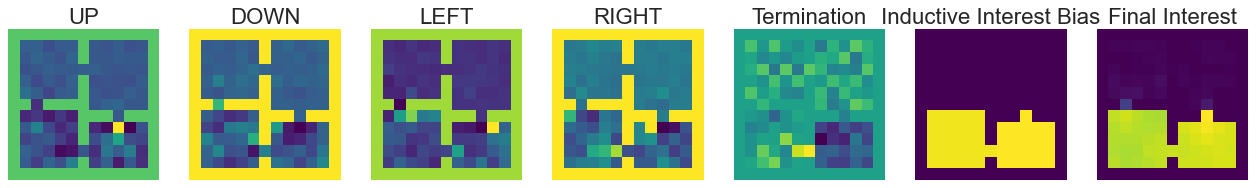

Option  3


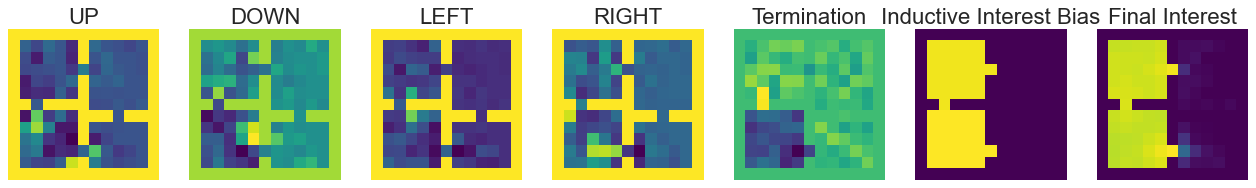

In [21]:
count_graph_plot = 0
run_to_show = 0 # run number of experiment

num_options = 4
#init_states = env.init_states
init_states = list(range(env.observation_space.n))
    
up_probs = []
down_probs = []
right_probs = []
left_probs = []
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
W = option_policies.options_W
b = option_policies.options_b

for option in range(0, num_options):
    up_temp = np.copy(mat_layout)
    down_temp = np.copy(mat_layout)
    right_temp = np.copy(mat_layout)
    left_temp = np.copy(mat_layout)
    for obs in init_states:

        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()

        logits = state @ W[option] + b[option]
        action_dist = (logits /1).softmax(dim=-1)
        action_dist = Categorical(action_dist)

        probs = action_dist.probs
        #print("State = ", state, " Probs = ", probs)
        
        row, col = mapping_state_row_col[obs]
        up_temp[row, col] =  probs[0]
        down_temp[row, col] =  probs[1]
        left_temp[row, col] =  probs[2]
        right_temp[row, col] =  probs[3]
        
    up_probs.append(up_temp)
    down_probs.append(down_temp)
    right_probs.append(right_temp)
    left_probs.append(left_temp)
    print("Done with option ", option)


for i in range(num_options):
    print("Option ", i)
    fix, axs = plt.subplots(1,7, figsize=(20, 20))
    sn.set(font_scale=0.6)
    #plt.figure(figsize=(5,5))
    sn.heatmap(up_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[0], xticklabels=False, yticklabels=False)
    sn.heatmap(down_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[1], xticklabels=False, yticklabels=False)
    sn.heatmap(left_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[2], xticklabels=False, yticklabels=False)
    sn.heatmap(right_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[3], xticklabels=False, yticklabels=False)
    sn.heatmap(term_mats[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[4], xticklabels=False, yticklabels=False)
    sn.heatmap(initial_int_mats[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[5], xticklabels=False, yticklabels=False)
    sn.heatmap(final_interest[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[6], xticklabels=False, yticklabels=False)
    axs[0].set_title('UP', fontsize=20)
    axs[1].set_title('DOWN', fontsize=20)
    axs[2].set_title('LEFT', fontsize=20)
    axs[3].set_title('RIGHT', fontsize=20)
    axs[4].set_title('Termination', fontsize=20)
    axs[5].set_title('Inductive Interest Bias', fontsize=20)
    axs[6].set_title('Final Interest', fontsize=20)
    plt.show()
    plt.close()

# Ignore

In [38]:
# Note that in the final interest, there is nothing in the right hallway if it didn't pre-exist

Done with option  0
Done with option  1
Done with option  2
Done with option  3
Option  0


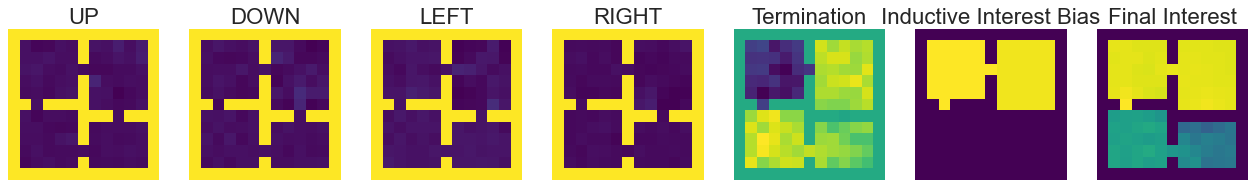

Option  1


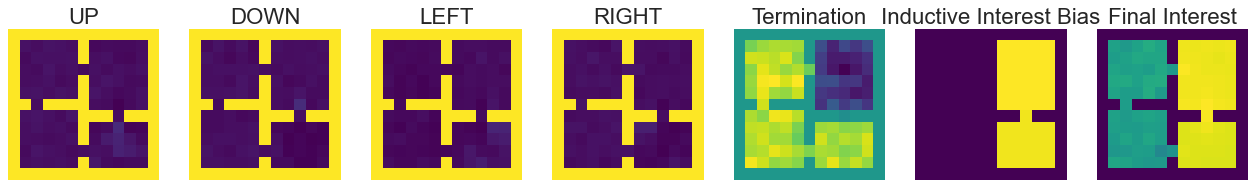

Option  2


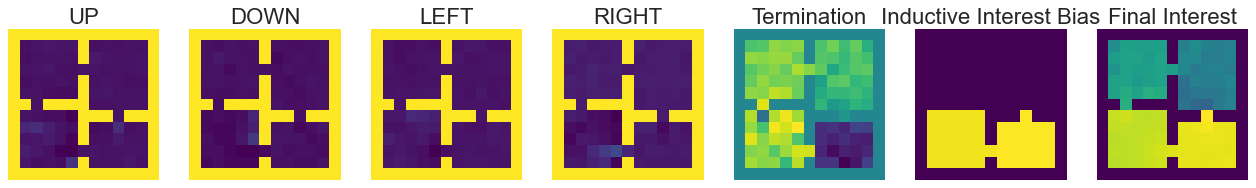

Option  3


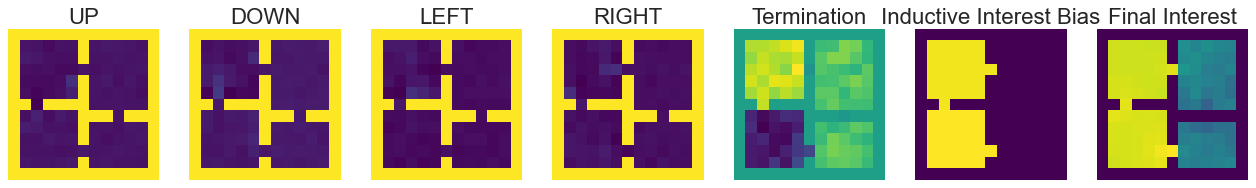

In [39]:
count_graph_plot = 0
run_to_show = 0 # run number of experiment

num_options = 4
#init_states = env.init_states
init_states = list(range(env.observation_space.n))
    
up_probs = []
down_probs = []
right_probs = []
left_probs = []
mat_layout , ann_layout, mapping_state_row_col = getEnvLayout(layout)
W = option_policies.options_W
b = option_policies.options_b

for option in range(0, num_options):
    up_temp = np.copy(mat_layout)
    down_temp = np.copy(mat_layout)
    right_temp = np.copy(mat_layout)
    left_temp = np.copy(mat_layout)
    for obs in init_states:

        state_arr = env.tocell[obs]
        state = env.states[(state_arr[0], state_arr[1])]
        state = torch.tensor(state).float()

        logits = state @ W[option] + b[option]
        action_dist = (logits /1).softmax(dim=-1)
        action_dist = Categorical(action_dist)

        probs = action_dist.probs
        #print("State = ", state, " Probs = ", probs)
        
        row, col = mapping_state_row_col[obs]
        up_temp[row, col] =  probs[0]
        down_temp[row, col] =  probs[1]
        left_temp[row, col] =  probs[2]
        right_temp[row, col] =  probs[3]
        
    up_probs.append(up_temp)
    down_probs.append(down_temp)
    right_probs.append(right_temp)
    left_probs.append(left_temp)
    print("Done with option ", option)


for i in range(num_options):
    print("Option ", i)
    fix, axs = plt.subplots(1,7, figsize=(20, 20))
    sn.set(font_scale=0.6)
    #plt.figure(figsize=(5,5))
    sn.heatmap(up_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[0], xticklabels=False, yticklabels=False)
    sn.heatmap(down_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[1], xticklabels=False, yticklabels=False)
    sn.heatmap(left_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[2], xticklabels=False, yticklabels=False)
    sn.heatmap(right_probs[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[3], xticklabels=False, yticklabels=False)
    sn.heatmap(term_mats[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[4], xticklabels=False, yticklabels=False)
    sn.heatmap(initial_int_mats[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[5], xticklabels=False, yticklabels=False)
    sn.heatmap(final_interest[i], fmt = '', cmap="viridis", cbar = False, square=True, ax = axs[6], xticklabels=False, yticklabels=False)
    axs[0].set_title('UP', fontsize=20)
    axs[1].set_title('DOWN', fontsize=20)
    axs[2].set_title('LEFT', fontsize=20)
    axs[3].set_title('RIGHT', fontsize=20)
    axs[4].set_title('Termination', fontsize=20)
    axs[5].set_title('Inductive Interest Bias', fontsize=20)
    axs[6].set_title('Final Interest', fontsize=20)
    plt.show()
    plt.close()